In [1]:
import torch
import torchvision
import torchvision.transforms as T
import pandas as pd
from PIL import Image
import os
import logging
from torch.utils.data import Dataset

print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


PyTorch version: 2.5.1+cu118
Device: cuda


In [2]:
acuity_path = "../acuityvalues_modified_based_on_sphere.xlsx"

df = pd.read_excel(acuity_path)

display(df.head())

print("Columns in the dataset:")
print(df.columns)

,patient,r sphere,r cylinder,l sphere,l cylinder,r class,l class
0,1,0.25,-0.25,0.00,-0.25,2,0
1,2,-0.50,-0.50,0.00,-0.50,1,0
2,3,1.75,-0.75,0.00,-0.25,2,0
3,4,0.25,0.00,0.25,0.00,2,2
4,5,0.25,0.25,0.25,0.00,2,2


Columns in the dataset:
Index(['patient', 'r sphere', 'r cylinder', 'l sphere', 'l cylinder',
       'r class', 'l class'],
      dtype='object')


In [3]:
import pandas as pd
import os
import logging

# Setup Logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the Excel data
def load_excel_data(filepath):
    """
    Load Excel data and drop rows with missing patient IDs or class values.
    """
    logging.info("Loading Excel data from: %s", filepath)
    data = pd.read_excel(filepath)
    initial_count = len(data)

    # Drop rows where 'patient', 'r class', or 'l class' are NaN
    data = data.dropna(subset=['patient', 'r class', 'l class'])
    cleaned_count = len(data)

    logging.info("Total rows in Excel: %d", initial_count)
    logging.info("Rows after dropping missing patient IDs or class values: %d", cleaned_count)

    # Ensure patient IDs are integers
    data['patient'] = data['patient'].apply(lambda x: int(x) if pd.notnull(x) else x)
    return data

# Verify that all required images exist for a patient
def verify_images(data, root_dir):
    """
    Check if all required images exist for each patient. Drop rows if any image is missing.
    """
    valid_rows = []
    for _, row in data.iterrows():
        patient_id = int(row['patient'])  # Ensure patient ID is an integer
        # Folder path for this patient
        patient_folder = os.path.join(root_dir, str(patient_id))

        # Expected image paths
        left_ir = os.path.normpath(os.path.join(patient_folder, f"{patient_id}_LEFT_IR.jpg")).replace("\\", "/")
        right_ir = os.path.normpath(os.path.join(patient_folder, f"{patient_id}_RIGHT_IR.jpg")).replace("\\", "/")

        # Check if both images exist
        left_exists = os.path.exists(left_ir)
        right_exists = os.path.exists(right_ir)

        if left_exists and right_exists:
            valid_rows.append(row)
        else:
            missing_files = []
            if not left_exists:
                missing_files.append(left_ir)
            if not right_exists:
                missing_files.append(right_ir)

            logging.warning(
                "Missing images for patient %d. Missing files: %s",
                patient_id,
                ", ".join(missing_files)
            )

    # Create a filtered DataFrame with valid rows
    filtered_data = pd.DataFrame(valid_rows, columns=data.columns)
    logging.info("Total valid patients with all images: %d", len(filtered_data))
    return filtered_data

# Create a reusable pipeline
def preprocess_data(excel_path, root_dir):
    """
    Main function to preprocess the data:
    1. Load and clean the Excel data.
    2. Verify the existence of corresponding images.
    3. Return a DataFrame with valid entries and associated image paths.
    """
    # Step 1: Load the Excel data
    data = load_excel_data(excel_path)

    # Step 2: Verify images
    valid_data = verify_images(data, root_dir)

    # Step 3: Add image paths to the DataFrame for easier access
    valid_data['left_image_path'] = valid_data['patient'].apply(
        lambda pid: os.path.normpath(
            os.path.join(root_dir, str(int(pid)), f"{int(pid)}_LEFT_IR.jpg")
        ).replace("\\", "/")
    )
    valid_data['right_image_path'] = valid_data['patient'].apply(
        lambda pid: os.path.normpath(
            os.path.join(root_dir, str(int(pid)), f"{int(pid)}_RIGHT_IR.jpg")
        ).replace("\\", "/")
    )

    return valid_data

# Path to the Excel file and root directory
EXCEL_PATH = r"D:\Power-Prediction\acuityvalues_modified_based_on_sphere.xlsx"
ROOT_DIR = r"../Choithram Netralaya Data/Images"

# Process the data
cleaned_data = preprocess_data(EXCEL_PATH, ROOT_DIR)

# Display the count of valid patients
logging.info("Final count of valid patients: %d", len(cleaned_data))

# Save the cleaned data to a CSV for reuse if needed
cleaned_data.to_csv("cleaned_data.csv", index=False)

# Display the first few rows
print(cleaned_data.head())

2024-12-25 19:45:41,621 - INFO - Loading Excel data from: D:\Power-Prediction\acuityvalues_modified_based_on_sphere.xlsx
2024-12-25 19:45:41,640 - INFO - Total rows in Excel: 336
2024-12-25 19:45:41,655 - INFO - Rows after dropping missing patient IDs or class values: 336
2024-12-25 19:45:41,655 - WARNING - Missing images for patient 1. Missing files: ../Choithram Netralaya Data/Images/1/1_LEFT_IR.jpg
2024-12-25 19:45:41,706 - WARNING - Missing images for patient 188. Missing files: ../Choithram Netralaya Data/Images/188/188_RIGHT_IR.jpg
2024-12-25 19:45:41,720 - WARNING - Missing images for patient 249. Missing files: ../Choithram Netralaya Data/Images/249/249_RIGHT_IR.jpg
2024-12-25 19:45:41,720 - WARNING - Missing images for patient 250. Missing files: ../Choithram Netralaya Data/Images/250/250_RIGHT_IR.jpg
2024-12-25 19:45:41,720 - WARNING - Missing images for patient 284. Missing files: ../Choithram Netralaya Data/Images/284/284_LEFT_IR.jpg
2024-12-25 19:45:41,734 - WARNING - Miss

   patient  r sphere  r cylinder  l sphere  l cylinder  r class  l class  \
1      2.0     -0.50       -0.50      0.00       -0.50      1.0      0.0   
2      3.0      1.75       -0.75      0.00       -0.25      2.0      0.0   
3      4.0      0.25        0.00      0.25        0.00      2.0      2.0   
4      5.0      0.25        0.25      0.25        0.00      2.0      2.0   
5      6.0     -1.50       -1.25     -0.75       -1.25      1.0      1.0   

                                     left_image_path  \
1  ../Choithram Netralaya Data/Images/2/2_LEFT_IR...   
2  ../Choithram Netralaya Data/Images/3/3_LEFT_IR...   
3  ../Choithram Netralaya Data/Images/4/4_LEFT_IR...   
4  ../Choithram Netralaya Data/Images/5/5_LEFT_IR...   
5  ../Choithram Netralaya Data/Images/6/6_LEFT_IR...   

                                    right_image_path  
1  ../Choithram Netralaya Data/Images/2/2_RIGHT_I...  
2  ../Choithram Netralaya Data/Images/3/3_RIGHT_I...  
3  ../Choithram Netralaya Data/Images/4/4

In [4]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import logging

# Setup Logger
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Dataset Class
class EyeDataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        patient_id = int(row['patient'])  # Ensure patient ID is an integer
        left_image_path = os.path.normpath(os.path.join(self.root_dir, str(patient_id), f"{patient_id}_LEFT_IR.jpg"))
        right_image_path = os.path.normpath(os.path.join(self.root_dir, str(patient_id), f"{patient_id}_RIGHT_IR.jpg"))

        # Check if image files exist
        if not os.path.exists(left_image_path):
            raise FileNotFoundError(f"Left IR image not found: {left_image_path}")
        if not os.path.exists(right_image_path):
            raise FileNotFoundError(f"Right IR image not found: {right_image_path}")

        # Load images
        left_image = Image.open(left_image_path).convert("RGB")
        right_image = Image.open(right_image_path).convert("RGB")

        if self.transform:
            left_image = self.transform(left_image)
            right_image = self.transform(right_image)

        # Labels
        labels = torch.tensor([row['r class'], row['l class']], dtype=torch.long)

        return (left_image, right_image), labels

# Load cleaned data
cleaned_data_path = "cleaned_data.csv"
if not os.path.exists(cleaned_data_path):
    raise FileNotFoundError(f"Cleaned data file not found: {cleaned_data_path}")

logging.info("Loading cleaned data...")
cleaned_data = pd.read_csv(cleaned_data_path)

# Ensure patient IDs are integers in the DataFrame
cleaned_data['patient'] = cleaned_data['patient'].apply(lambda x: int(x))

# Split data
logging.info("Splitting data into training and testing sets...")
train_data, test_data = train_test_split(cleaned_data, test_size=0.2, random_state=42)

# Define transformations
logging.info("Defining image transformations...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create datasets
logging.info("Creating datasets...")
train_dataset = EyeDataset(train_data, root_dir="../Choithram Netralaya Data/Images", transform=transform)
test_dataset = EyeDataset(test_data, root_dir="../Choithram Netralaya Data/Images", transform=transform)

# Data loaders
logging.info("Creating data loaders...")
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

logging.info("Data loaders created successfully.")

2024-12-25 19:45:43,590 - INFO - Loading cleaned data...
2024-12-25 19:45:43,590 - INFO - Splitting data into training and testing sets...
2024-12-25 19:45:43,606 - INFO - Defining image transformations...
2024-12-25 19:45:43,606 - INFO - Creating datasets...
2024-12-25 19:45:43,606 - INFO - Creating data loaders...
2024-12-25 19:45:43,606 - INFO - Data loaders created successfully.


In [5]:
sample = train_dataset[0]
print("Left Image Shape:", sample[0][0].shape)
print("Right Image Shape:", sample[0][1].shape)
print("Labels:", sample[1])

Left Image Shape: torch.Size([3, 224, 224])
Right Image Shape: torch.Size([3, 224, 224])
Labels: tensor([1, 2])


In [6]:
for (left_images, right_images), labels in train_loader:
    print("Batch Left Images Shape:", left_images.shape)
    print("Batch Right Images Shape:", right_images.shape)
    print("Labels Shape:", labels.shape)
    break


Batch Left Images Shape: torch.Size([8, 3, 224, 224])
Batch Right Images Shape: torch.Size([8, 3, 224, 224])
Labels Shape: torch.Size([8, 2])


In [7]:
for idx in range(5):
    row = train_dataset.data.iloc[idx]
    print(f"Patient ID: {row['patient']}, Left Image Path: {row['left_image_path']}, Right Image Path: {row['right_image_path']}")
    print(f"r class: {row['r class']}, l class: {row['l class']}")


Patient ID: 185, Left Image Path: ../Choithram Netralaya Data/Images/185/185_LEFT_IR.jpg, Right Image Path: ../Choithram Netralaya Data/Images/185/185_RIGHT_IR.jpg
r class: 1.0, l class: 2.0
Patient ID: 19, Left Image Path: ../Choithram Netralaya Data/Images/19/19_LEFT_IR.jpg, Right Image Path: ../Choithram Netralaya Data/Images/19/19_RIGHT_IR.jpg
r class: 1.0, l class: 1.0
Patient ID: 26, Left Image Path: ../Choithram Netralaya Data/Images/26/26_LEFT_IR.jpg, Right Image Path: ../Choithram Netralaya Data/Images/26/26_RIGHT_IR.jpg
r class: 1.0, l class: 1.0
Patient ID: 134, Left Image Path: ../Choithram Netralaya Data/Images/134/134_LEFT_IR.jpg, Right Image Path: ../Choithram Netralaya Data/Images/134/134_RIGHT_IR.jpg
r class: 1.0, l class: 1.0
Patient ID: 115, Left Image Path: ../Choithram Netralaya Data/Images/115/115_LEFT_IR.jpg, Right Image Path: ../Choithram Netralaya Data/Images/115/115_RIGHT_IR.jpg
r class: 2.0, l class: 2.0


In [8]:
print("Unique values in r class:", train_data['r class'].unique())
print("Unique values in l class:", train_data['l class'].unique())


Unique values in r class: [1. 2. 0.]
Unique values in l class: [2. 1. 0.]


In [9]:
import torch.nn as nn
from torchvision import models
from torchvision.models import EfficientNet_B2_Weights

class EyeClassificationModel(nn.Module):
    def __init__(self, num_classes=3):
        super(EyeClassificationModel, self).__init__()
        # Load EfficientNet B2
        self.efficientnet = models.efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, 256)  # Extract features

        # Fully connected layer for classification
        self.fc = nn.Sequential(
            nn.Linear(256 * 2, 256),  # Combine features from both eyes
            nn.ReLU(),
            nn.Linear(256, num_classes * 2)  # Output for r class and l class
        )

    def forward(self, left_image, right_image):
        # Extract features from left and right images
        left_features = self.efficientnet(left_image)
        right_features = self.efficientnet(right_image)

        # Concatenate features
        combined_features = torch.cat((left_features, right_features), dim=1)

        # Pass through fully connected layer
        outputs = self.fc(combined_features)

        # Separate outputs for r class and l class
        r_class_output = outputs[:, :3]  # First three outputs for r class
        l_class_output = outputs[:, 3:]  # Next three outputs for l class
        return r_class_output, l_class_output

In [13]:

def train_model(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for (left_images, right_images), labels in dataloader:
            left_images, right_images = left_images.to(device), right_images.to(device)
            r_class_labels, l_class_labels = labels[:, 0].to(device), labels[:, 1].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            r_class_output, l_class_output = model(left_images, right_images)

            # Compute loss
            loss_r = criterion(r_class_output, r_class_labels)
            loss_l = criterion(l_class_output, l_class_labels)
            loss = loss_r + loss_l

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(dataloader)}")


In [14]:
def evaluate_model(model, dataloader):
    model.eval()
    correct_r, correct_l = 0, 0
    total = 0

    with torch.no_grad():
        for (left_images, right_images), labels in dataloader:
            left_images, right_images = left_images.to(device), right_images.to(device)
            r_class_labels, l_class_labels = labels[:, 0].to(device), labels[:, 1].to(device)

            # Forward pass
            r_class_output, l_class_output = model(left_images, right_images)

            # Predictions
            _, predicted_r = torch.max(r_class_output, 1)
            _, predicted_l = torch.max(l_class_output, 1)

            total += labels.size(0)
            correct_r += (predicted_r == r_class_labels).sum().item()
            correct_l += (predicted_l == l_class_labels).sum().item()

    accuracy_r = 100 * correct_r / total
    accuracy_l = 100 * correct_l / total
    print(f"Right Eye Accuracy: {accuracy_r:.2f}%")
    print(f"Left Eye Accuracy: {accuracy_l:.2f}%")


In [15]:
model = EyeClassificationModel(num_classes=3).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
print("Training model...")
train_model(model, train_loader, criterion, optimizer, epochs=30)

Training model...
Epoch 1/30, Loss: 1.5997589898831917
Epoch 2/30, Loss: 1.3184539332534329
Epoch 3/30, Loss: 1.2692180131420945
Epoch 4/30, Loss: 1.345139610044884
Epoch 5/30, Loss: 1.1942945610393176
Epoch 6/30, Loss: 0.9848263805562799
Epoch 7/30, Loss: 0.894220645680572
Epoch 8/30, Loss: 0.6459179166139979
Epoch 9/30, Loss: 0.7919321398843419
Epoch 10/30, Loss: 0.8337163198174853
Epoch 11/30, Loss: 0.6304372473986763
Epoch 12/30, Loss: 0.65396441304774
Epoch 13/30, Loss: 0.5660620560926019
Epoch 14/30, Loss: 0.49116140445976547
Epoch 15/30, Loss: 0.40009747135142487
Epoch 16/30, Loss: 0.3959970342729128
Epoch 17/30, Loss: 0.34744741361249576
Epoch 18/30, Loss: 0.27120166695253417
Epoch 19/30, Loss: 0.36228063981980085
Epoch 20/30, Loss: 0.44150315275923774
Epoch 21/30, Loss: 0.1965312214398926
Epoch 22/30, Loss: 0.17514789218054802
Epoch 23/30, Loss: 0.1775484825625564
Epoch 24/30, Loss: 0.12438874496288146
Epoch 25/30, Loss: 0.12131097546962062
Epoch 26/30, Loss: 0.233097676540527

In [16]:
# Evaluate the model
print("Evaluating model...")
evaluate_model(model, test_loader)


Evaluating model...
Right Eye Accuracy: 74.24%
Left Eye Accuracy: 74.24%


In [18]:
def evaluate_model_with_metrics(model, dataloader):
    model.eval()
    correct_r, correct_l = 0, 0
    total = 0

    r_class_true, r_class_pred = [], []
    l_class_true, l_class_pred = [], []

    with torch.no_grad():
        for (left_images, right_images), labels in dataloader:
            left_images, right_images = left_images.to(device), right_images.to(device)
            r_class_labels, l_class_labels = labels[:, 0].to(device), labels[:, 1].to(device)

            # Forward pass
            r_class_output, l_class_output = model(left_images, right_images)

            # Predictions
            _, predicted_r = torch.max(r_class_output, 1)
            _, predicted_l = torch.max(l_class_output, 1)

            # Store true and predicted labels
            r_class_true.extend(r_class_labels.cpu().numpy())
            r_class_pred.extend(predicted_r.cpu().numpy())
            l_class_true.extend(l_class_labels.cpu().numpy())
            l_class_pred.extend(predicted_l.cpu().numpy())

            total += labels.size(0)
            correct_r += (predicted_r == r_class_labels).sum().item()
            correct_l += (predicted_l == l_class_labels).sum().item()

    accuracy_r = 100 * correct_r / total
    accuracy_l = 100 * correct_l / total
    print(f"Right Eye Accuracy: {accuracy_r:.2f}%")
    print(f"Left Eye Accuracy: {accuracy_l:.2f}%")

    return r_class_true, r_class_pred, l_class_true, l_class_pred


In [20]:
r_class_true, r_class_pred, l_class_true, l_class_pred = evaluate_model_with_metrics(model, test_loader)


Right Eye Accuracy: 74.24%
Left Eye Accuracy: 74.24%


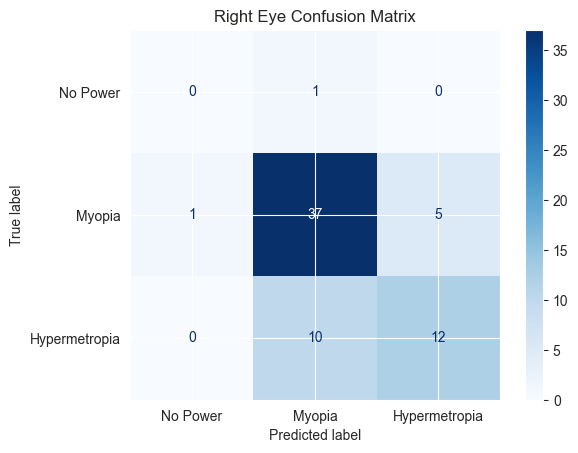

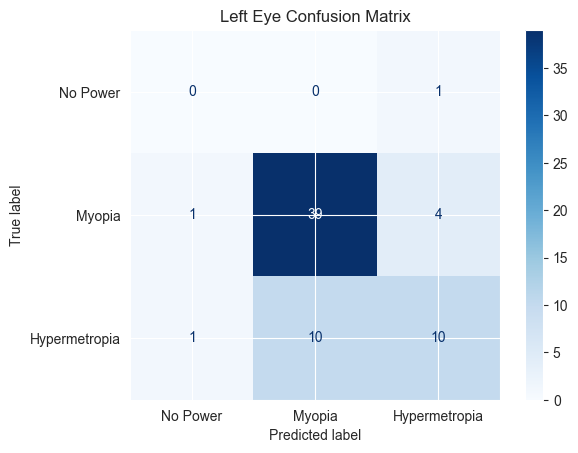

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, predicted_labels, title):
    cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Power", "Myopia", "Hypermetropia"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Right Eye Confusion Matrix
plot_confusion_matrix(r_class_true, r_class_pred, "Right Eye Confusion Matrix")

# Left Eye Confusion Matrix
plot_confusion_matrix(l_class_true, l_class_pred, "Left Eye Confusion Matrix")


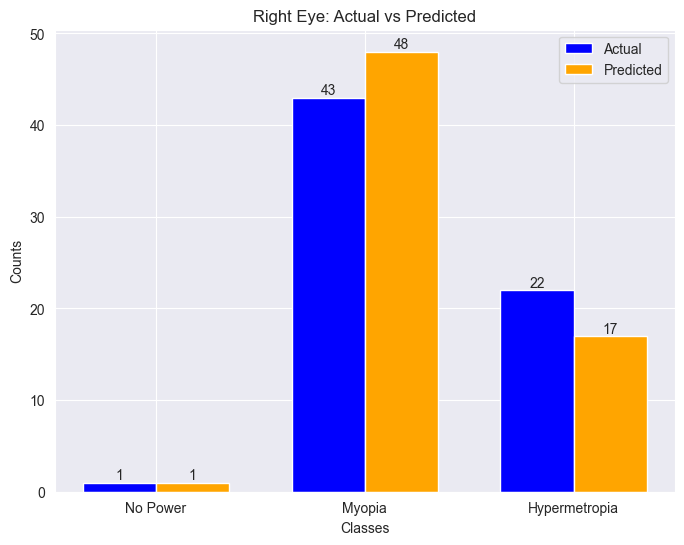

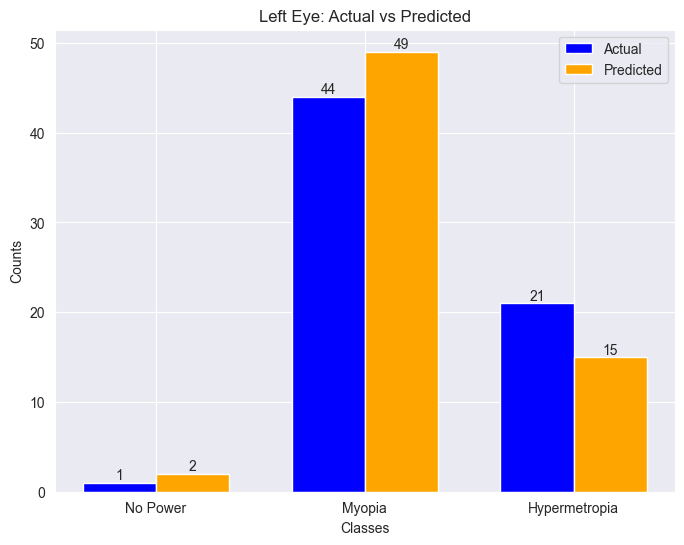

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_actual_vs_predicted(actual, predicted, title):
    classes = ["No Power", "Myopia", "Hypermetropia"]

    # Count occurrences for each class
    actual_counts = [actual.count(i) for i in range(3)]
    predicted_counts = [predicted.count(i) for i in range(3)]

    # Plotting
    x = np.arange(len(classes))  # Class indices
    width = 0.35  # Bar width

    fig, ax = plt.subplots(figsize=(8, 6))
    bars1 = ax.bar(x - width/2, actual_counts, width, label='Actual', color='blue')
    bars2 = ax.bar(x + width/2, predicted_counts, width, label='Predicted', color='orange')

    # Add labels, title, and legend
    ax.set_xlabel('Classes')
    ax.set_ylabel('Counts')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    # Add value labels on the bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

    plt.show()

# Plot for Right Eye
plot_actual_vs_predicted(r_class_true, r_class_pred, "Right Eye: Actual vs Predicted")

# Plot for Left Eye
plot_actual_vs_predicted(l_class_true, l_class_pred, "Left Eye: Actual vs Predicted")


In [23]:
# Save the model
model_path = "eye_classification_model_model-1-b2.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to eye_classification_model_model-1-b2.pth
